In [ ]:
!pip install git+https://github.com/kaanaksit/odak.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/kaanaksit/odak.git to /tmp/pip-req-build-vzg802qf
  Running command git clone -q https://github.com/kaanaksit/odak.git /tmp/pip-req-build-vzg802qf


In [ ]:
import odak
import torch 
import numpy as np 
import odak.learn.raytracing as ODL
import matplotlib.pyplot as plt
import math
import odak.raytracing as raytracer
import odak.tools as tools
import odak.raytracing as raytracer
import torch.nn as nn
from odak.raytracing.ray import create_ray
import cv2
from PIL import Image
import sys
import torch.optim as optim
from torchvision import transforms
from torch.nn import Module
import math

In [ ]:
class aperture_array():

  def __init__(self, device):
    self.device = device
    
    self.init_light_sources()
    self.init_aperture_array()
    self.init_detector()
    # self.transform_image()
    

  def transform_image(self, image):
    transform =transforms.Compose([
        transforms.Resize((28,28)),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
        
    ])
    normalised_image = transform(image).view(-1,1).to(self.device)
    
    return normalised_image

  
  def init_light_sources(self, dimensions=[0.01, 0.015], pixel_count=[28,28], Z=0.):
      x = torch.linspace(-dimensions[0]/2., dimensions[0]/2., pixel_count[0])
      y = torch.linspace(-dimensions[1]/2., dimensions[1]/2., pixel_count[1])
      X, Y = torch.meshgrid(x, y, indexing='ij')
      self.light_source_locations = torch.zeros(X.shape[0], X.shape[1], 3).to(self.device)
      self.light_source_locations[:, :, 0] = X
      self.light_source_locations[:, :, 1] = Y
      self.light_source_locations[:, :, 2] = Z
      
      
  def init_aperture_array(self, dimensions=[0.01, 0.015], pixel_count=[28,28], Z=0.01):
        x = torch.linspace(-dimensions[0]/2., dimensions[0]/2., pixel_count[0])
        y = torch.linspace(-dimensions[1]/2., dimensions[1]/2., pixel_count[1])
        X, Y = torch.meshgrid(x, y, indexing='ij')
        self.aperture_array_locations = torch.zeros(X.shape[0], X.shape[1], 3).to(self.device)
        self.aperture_array_locations[:, :, 0] = X
        self.aperture_array_locations[:, :, 1] = Y
        self.aperture_array_locations[:, :, 2] = Z
        self.aperture_array = torch.rand(X.shape[0], X.shape[1], requires_grad=True, device=self.device) 

        return self.aperture_array
        
        
  def init_detector(self, dimensions=[0.01, 0.015], size=[28,28], Z=0.01):
        
        point = torch.tensor([0., 0., Z]).to(self.device)
        self.detector_surface = odak.learn.raytracing.define_plane(point)
        
        
  def intersection_points_to_image(self, points, amplitudes, threshold, norm_image):
   
        Points_data= norm_image * amplitudes
        detector = torch.zeros_like(Points_data).to(self.device)
        array_locations = self.aperture_array_locations.view(-1, 3)

        

        for i in points: 
          for idx, point in enumerate(i):
            
        
            dist_btwn_array_npoint = torch.sqrt(torch.sum((array_locations-point)**2, dim=1))
            min_dist_idx  = torch.argmin(dist_btwn_array_npoint)
            min_dist = torch.min(dist_btwn_array_npoint)

            if min_dist < (math.sqrt(2) * threshold):
              detector[min_dist_idx] = Points_data[idx]

          detector +=detector
              
        detector = detector.view(28,28)
        return detector
  
  def forward(self, array, image):
        light_source_locations = self.light_source_locations.view(-1, 3)

        aperture_array_locations = self.aperture_array_locations.view(-1, 3)

        detector_image  = torch.zeros(28,28).to(self.device)
        self.pixel_pitch = torch.sqrt(torch.sum((aperture_array_locations[1] - aperture_array_locations[0])**2, dim =0)).to(self.device)

        aperture_array = array.view(-1,1)
        self.img = image
        self.norm_img = self.transform_image(image) #size(600,1)

        intersections = []
        
        for light_source_location in light_source_locations:
            rays_from_light_source = odak.learn.raytracing.create_ray_from_two_points(light_source_location, aperture_array_locations)

             # calculating intersection points
            intersection_normals_w_detector, _ = odak.learn.raytracing.intersect_w_surface(rays_from_light_source, self.detector_surface)
            intersection_points_w_detector = intersection_normals_w_detector[:, 0]
            intersections.append(intersection_points_w_detector)
            
            
        # Getting the image seen on the image plane
        detector_image = self.intersection_points_to_image(
                                                            intersections,
                                                            aperture_array, 
                                                            self.pixel_pitch,
                                                            self.norm_img
                                                          )  
        return detector_image, intersections

  def compute_loss(self, output , target):
    loss = torch.nn.MSELoss()(output, target)

    return loss
            
  def optimize(self, intersection_points):
        
        # 
        target= self.norm_img.view(28,28) #size(28,28)


        array = self.aperture_array.view(-1,1)
        array_loc = self.aperture_array_locations

        model = [nn.Parameter(array)]

        points= intersection_points
        threshold= self.pixel_pitch

       
        optimiser= torch.optim.SGD(model,lr = 0.1,momentum=0.9)
        epochs= 200

        for epoch in range(0, epochs+1):
          optimiser.zero_grad()
          
          output=self.intersection_points_to_image(points, model[0], threshold, self.norm_img)
          loss = self.compute_loss(output,target)
            
          loss.backward()
          optimiser.step()

          print('Epoch: ', epoch,' ,Loss: ', loss)

        return model, output
  
def main():
    device = torch.device('cuda')
    apertures = aperture_array(device=device)
    result = apertures.optimize()
    return True







In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Aperture_RT= aperture_array(device)

In [ ]:
import tensorflow as tf 

(x_train , y_train) , (x_test, y_test )= tf.keras.datasets.fashion_mnist.load_data()



4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
#test_img_2 = Image.fromarray(x_train[7]).convert('L')

test_img_4 = Image.open('/content/pixil-frame-0.png').convert('L')
#/content/heart.png
array = Aperture_RT.init_aperture_array()# initial value of the aperture array yet to be optimised

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28,28)),
    transforms.Normalize((0.5), (0.5))
])

resize_image = transform(test_img_4).to(device)
ray_traced_image, intersection_points= Aperture_RT.forward(array,test_img_4)

Text(0.5, 1.0, 'Image ray traced through array')

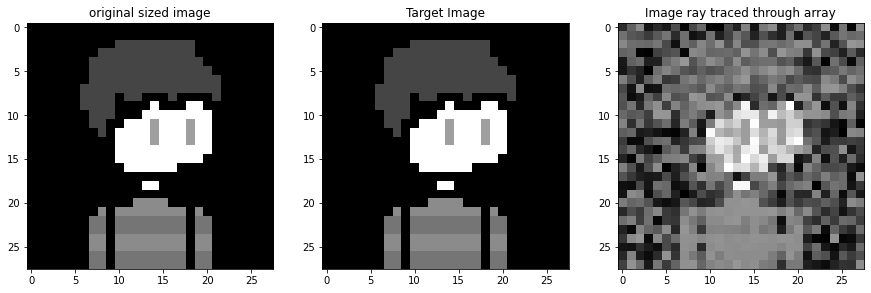

In [ ]:
fig , axes=plt.subplots(1,3, figsize =(15, 15))

axes[0].imshow(test_img_4, cmap='gray')
axes[0].set_title('original sized image')

axes[1].imshow(resize_image.cpu().squeeze(), cmap='gray')
axes[1].set_title('Target Image')

axes[2].imshow(ray_traced_image.detach().cpu().numpy()*255, cmap='gray')
axes[2].set_title('Image ray traced through array')

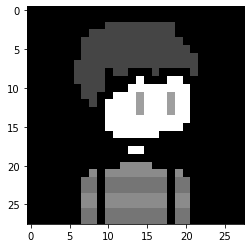

In [ ]:
plt.imshow(test_img_4, cmap='gray')
#plt.title('Image ray traced through array')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/MASTERS PROJECT /Tests/Test_4/test_image.png',bbox_inches='tight',pad_inches = 0)
plt.show()

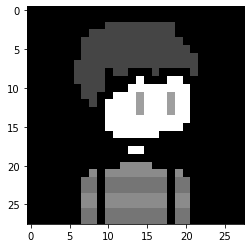

In [ ]:
plt.imshow(resize_image.cpu().squeeze(), cmap='gray')
#plt.title('Image ray traced through array')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/MASTERS PROJECT /Tests/Test_4/resized_image.png',bbox_inches='tight',pad_inches = 0)
plt.show()

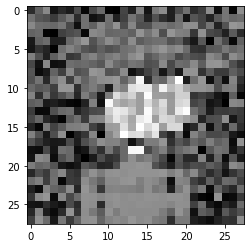

In [ ]:
plt.imshow(ray_traced_image.detach().cpu().numpy()*255, cmap='gray')
#plt.title('Image ray traced through array')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/MASTERS PROJECT /Tests/Test_4/Ray_traced_image_2.png',bbox_inches='tight',pad_inches = 0)
plt.show()

In [ ]:
Loss = Aperture_RT.compute_loss(ray_traced_image, resize_image.squeeze())
print('The initial loss is: ',Loss)

The initial loss is:  tensor(0.2444, grad_fn=<MseLossBackward0>)


In [ ]:
# optim_4 = Aperture_RT.optimize(intersection_points)

Epoch:  0  ,Loss:  tensor(0.2444, grad_fn=<MseLossBackward0>)
Epoch:  1  ,Loss:  tensor(0.2440, grad_fn=<MseLossBackward0>)
Epoch:  2  ,Loss:  tensor(0.2431, grad_fn=<MseLossBackward0>)
Epoch:  3  ,Loss:  tensor(0.2418, grad_fn=<MseLossBackward0>)
Epoch:  4  ,Loss:  tensor(0.2403, grad_fn=<MseLossBackward0>)
Epoch:  5  ,Loss:  tensor(0.2384, grad_fn=<MseLossBackward0>)
Epoch:  6  ,Loss:  tensor(0.2362, grad_fn=<MseLossBackward0>)
Epoch:  7  ,Loss:  tensor(0.2339, grad_fn=<MseLossBackward0>)
Epoch:  8  ,Loss:  tensor(0.2313, grad_fn=<MseLossBackward0>)
Epoch:  9  ,Loss:  tensor(0.2286, grad_fn=<MseLossBackward0>)
Epoch:  10  ,Loss:  tensor(0.2257, grad_fn=<MseLossBackward0>)
Epoch:  11  ,Loss:  tensor(0.2227, grad_fn=<MseLossBackward0>)
Epoch:  12  ,Loss:  tensor(0.2196, grad_fn=<MseLossBackward0>)
Epoch:  13  ,Loss:  tensor(0.2164, grad_fn=<MseLossBackward0>)
Epoch:  14  ,Loss:  tensor(0.2132, grad_fn=<MseLossBackward0>)
Epoch:  15  ,Loss:  tensor(0.2099, grad_fn=<MseLossBackward0>)
Ep

In [ ]:
# #save optimised array
# path="/content/drive/MyDrive/Colab Notebooks/MASTERS PROJECT /Models/{optim_array_4.pt}"
# torch.save(optim_4[0][0], path)

In [ ]:
# Load Optimised array
path="/content/drive/MyDrive/Colab Notebooks/MASTERS PROJECT /Models/{optim_array_4.pt}"
optim_array_4  = torch.load(path)

In [ ]:
optimised_image, intersection =Aperture_RT.forward(optim_array_4,test_img_4)

Text(0.5, 1.0, 'Optimised image')

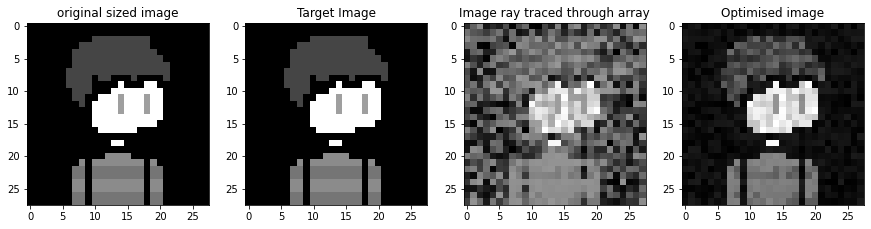

In [ ]:
fig , axes=plt.subplots(1,4, figsize =(15, 15))

axes[0].imshow(test_img_4, cmap='gray')
axes[0].set_title('original sized image')

axes[1].imshow(resize_image.cpu().squeeze(), cmap='gray')
axes[1].set_title('Target Image')

axes[2].imshow(ray_traced_image.detach().cpu().numpy()*255, cmap='gray')
axes[2].set_title('Image ray traced through array')



axes[3].imshow(optimised_image.detach().cpu().numpy()*255, cmap='gray')
axes[3].set_title('Optimised image')
# plt.colorbar()

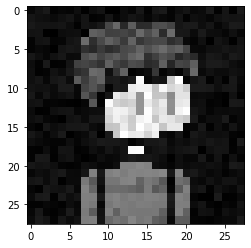

In [ ]:
plt.imshow(optimised_image.detach().cpu().numpy()*255, cmap='gray')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/MASTERS PROJECT /Tests/Test_4/optimised_img.png',bbox_inches='tight',pad_inches = 0)
plt.show()

## Using Optimised array for another image

In [ ]:
test_image = Image.open('/content/Test_image.png').convert('L')
resized_im = transform(test_image).to(device)
ray_traced_im =Aperture_RT.forward(optim_array.view(20,30),test_image)


In [ ]:
fig , axes=plt.subplots(1,3, figsize =(15, 15))

axes[0].imshow(test_image, cmap='gray')
axes[0].set_title('original image')

axes[1].imshow(resized_im.cpu().squeeze(), cmap='gray')
axes[1].set_title('Resized image')

axes[2].imshow(ray_traced_im.detach().cpu().numpy()*255, cmap='gray')
axes[2].set_title('Image ray traced with optimised array')

In [ ]:
import tensorflow as tf 

(x_train , y_train) , (x_test, y_test )= tf.keras.datasets.cifar10.load_data()